# Brief introduction to use VitalDB_signal extractor (https://vitaldb.net/)
-------
> 1.Input your file name (.vital) <br>
> 2.Select specific time <br>
> 3.Get specific signals <br>
> Known issue : several errors in sampling rate from .vital <br>

<img src="resource/VitalDB_s.png"/>


In [2]:
# import libaries
import torch
import os
import csv
import glob
import datetime 
import numpy as np
import pandas as pd
import AMCVitalReader as vr
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

from os import listdir
from os.path import isfile, join
import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def get_time_from_wave():
    a,b = vr_data.read_wave_datetime('DI-1120','VOLT')
    print("###File information###")
    print("[time start]",a[0])
    print("[time end]",a[-1])
    print("[time length]",a[-1]-a[0])
    print(len(a))
    return len(a)

def get_time_from_number():
    a,b = vr_data.read_number_datetime('Primus','CO2')
    print("[time start]",a[0])
    print("[time end]",a[-1])
    print("[time length]",a[-1]-a[0])
    print(len(a))
    return len(a)

def get_state_time(i):
    state_time=str(df_dict['Time'][i])
    start_year   = int(state_time[0:4])
    start_month  = int(state_time[5:7])
    start_date   = int(state_time[8:10])
    start_hour   = int(state_time[11:13])
    start_minute = int(state_time[14:16])
    start_second = int(state_time[17:19])

    state_time=str(df_dict['Time'][i+1])
    end_year   = int(state_time[0:4])
    end_month  = int(state_time[5:7])
    end_date   = int(state_time[8:10])
    end_hour   = int(state_time[11:13])
    end_minute = int(state_time[14:16])
    end_second = int(state_time[17:19])
    state = df_dict["State"][i]
    return start_year,start_month,start_date,start_hour,start_minute,start_second,end_year,end_month,end_date,end_hour,end_minute,end_second, state

def extract_original_wav():

    # CO2 : 1 frame 0.016s, 62.5Hz
    # AWP : 1 frame 0.016s, 62.5Hz
    # VOLT : 1 frame 0.004s, 2500Hz
    AWP_to_VOLT = 40
    
    plt.figure(figsize=(12,4))
    for i in range(0,len(device0_signal)+len(device1_signal)+len(device2_signal)):
        plt.plot(total_df[column_name[2*i]],total_df[column_name[2*i+1]],alpha=0.5,label=column_name[2*i+1])
    plt.legend(loc='upper left')
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(total_df[column_name[3]],alpha=0.3,label=column_name[1],color='blue')
    plt.legend(loc='upper left')
    
    breathing_start=[]
    breathing_end=[]
    margin_start = 30
    margin_end = 100
    time_delta = 20
    time_skip = 50

    i=0
    while i < len(total_df[column_name[3]]):
        i += 1
        if len(breathing_start) == len(breathing_end):
            if i < margin_start:
                i += time_skip
                continue
            if total_df[column_name[3]][i:i+time_delta].diff(time_delta-1).mean() > 0.09:
                breathing_start.append(i-margin_start)
#                 print('breathing_start',i,len(breathing_start),total_df[column_name[3]][i:i+time_delta].diff(time_delta-1).mean())
                plt.vlines(i-margin_start,-.2,1,colors='black') # trigger start 
                i += time_skip
        elif len(breathing_start) > len(breathing_end):
#             if breathing_start[-1] < i+margin_end: # fix n+1 start is started before n end
#                 i += time_skip
#                 continue
            if total_df[column_name[3]][i:i+time_delta].diff(time_delta-1).mean() < -0.15:
                breathing_end.append(i+margin_end)
#                 print('breathing_end  ',i,len(breathing_end),total_df[column_name[3]][i:i+time_delta].diff(time_delta-1).mean())
                plt.vlines(i+margin_end,-.2,1,colors='red') # trigger start
                i += time_skip
    if len(breathing_start) > len(breathing_end): # cut off non breathing end...
        breathing_start = breathing_start[:-1]
    print('count',len(breathing_start),len(breathing_end))
    plt.show()
    
    if len(breathing_start) == 0:
        print('there is no breathing data')
    else:
        plt.figure(figsize=(20,8))
        for i in range(0,len(breathing_start)):
            wav_original = np.asarray(total_df['VOLT'][breathing_start[i]*AWP_to_VOLT:breathing_end[i]*AWP_to_VOLT]).astype(np.float32)
            plt.subplot(2, int(len(breathing_start)/2)+1, i+1)
            librosa.display.waveplot(wav_original,label=i,alpha=0.5)
            plt.ylim(-2, 2)
            plt.legend()

            audio_path = 'output/'+fname+'/'+fname_with_time+'/'+fname_with_time+str("%03d" % i)+'.wav'
            librosa.output.write_wav(audio_path, wav_original*2.5, 2500) # gain 2.5

#     wav_path='output/'+fname+'/'+fname_with_time+'/'
#     import_raw_wav = [f for f in listdir(wav_path) if isfile(join(wav_path, f))]
#     import_raw_wav

def make_output_dirs():
    os.makedirs('output', exist_ok=True)        
    os.makedirs('output/'+fname, exist_ok=True)
    os.makedirs('output/'+fname+'/'+fname_with_time, exist_ok=True)
    
def HPSS():
    wav_path = 'output/'+fname+'/'+fname_with_time+'/'
    wav_file = glob.glob(wav_path+"*.wav")
    wav_file.sort()
    print("HPSS",len(wav_file))
    
    for i in range(0,len(wav_file)):
        y, sr = librosa.load(wav_file[i],2500)
        D = librosa.stft(y)
        D_harmonic, D_percussive = librosa.decompose.hpss(D,power=1,margin=1)
        audio_path = wav_file[i]
        librosa.output.write_wav(audio_path,librosa.istft(D_harmonic), sr)
#         audio_path = 'output/'+fname+'/'+fname_with_time+'/percussive/'+fname_with_time+str("%03d" % i)+'_percussive.wav'
#         librosa.output.write_wav(audio_path,librosa.istft(D_percussive), sr)
        
def draw_spectrum():
    wav_path='output/'+fname+'/'+fname_with_time+'/'
    wav_file = glob.glob(wav_path+"*.wav")
    wav_file.sort()
    print("draw_spectrum",len(wav_file))
    plt.figure(figsize=(22, 6))

    for i in range(0,len(wav_file)):
        y, sr = librosa.load(wav_file[i],2500)
        D = librosa.stft(y)
        plt.subplot(2, int(len(wav_file)/2)+1, i+1)
        librosa.display.specshow(librosa.amplitude_to_db(librosa.magphase(D)[0]), y_axis='log')
        plt.clim(-40, 50)
        plt.colorbar(format='%+2.0f dB')
        plt.title(str(i))
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,0,1024))
    plt.show()
    plt.savefig('output/'+fname+'/'+fname_with_time+'/'+fname_with_time+str("%03d" % i)+'_spectrum.png',bbox_inches='tight')
    
def draw_MFCC():
    wav_path='output/'+fname+'/'+fname_with_time+'/'
    wav_file = glob.glob(wav_path+"*.wav")
    wav_file.sort()
    print("draw_MFCC",len(wav_file))
    plt.figure(figsize=(22, 6))

    for i in range(0,len(wav_file)):
        y, sr = librosa.load(wav_file[i],2500)
        S = librosa.feature.melspectrogram(y, n_mels=128,n_fft=1024) #128, 1024
        log_S = librosa.amplitude_to_db(S, ref=np.max)
        mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=40)  #13?
        delta_mfcc  = librosa.feature.delta(mfcc)
        plt.subplot(2, int(len(wav_file)/2)+1, i+1)
        librosa.display.specshow(delta_mfcc)
        plt.colorbar(format='%+2.0f dB')
        plt.title(str(i))
    plt.show()

## 1.Input your file name (.vital)
-----

In [4]:

# fnamelist = ['F-07_180425_080352',         # the name of .vital file
# 'F-07_180425_095850',         # the name of .vital file
# 'F-07_180425_130337',        # the name of .vital file  # no good
# 'F-07_180502_145342',        # the name of .vital file
# 'F-07_180502_081156',         # the name of .vital file
# 'F-07_180509_080725',         # the name of .vital file
# 'F-07_180523_081444',         # the name of .vital file
# 'F-07_180523_120151',         # the name of .vital file
# 'F-07_180529_080912',         # the name of .vital file
# 'F-07_180530_080829',         # the name of .vital file
# 'F-07_180620_082056_52917604_Wedge resection',         # the name of .vital file _no CO2
# 'F-07_180627_081312_54963627_lungcaLLL',         # no good
# 'F-07_180627_104459_54982921_ung cancer RUL, emphysema', # GOOD breathing! noise should be remove! 
# 'F-07_180629_080515_20130400_lung cancer RUL', # GOOD
# 'F-07_180704_081003_54379493_wedge resection', # so so
# 'F-07_180704_124141_31796862_wedge resection', # no good
# 'F-07_180711_080442_26855435_RMLobectomy_PFT normal', # no good
# 'F-07_180711_111006_54998212_segmentectomy_mild restrictive pattern', # no good
# 'F-07_180725_080513_42619237_wedge resection_normal PFT', # no good
# 'F-07_180725_101446_55108959_lobectomy_mild obstructive pattern', # no good
# 'F-07_180725_132812_55288165_lobectomy_normal PFT emphysema on CT', # no good
# 'F-07_180727_082222_46956370_wedge resection_normal PFT', # no good
# 'F-07_180727_113039_50796849_wedge resection_normal PFT', # no good
# 'F-07_180808_080457_53218975_GGN, LLL', # no good
# 'F-07_180809_080641_55323501_lung ca RUL', # no good
# 'F-07_180822_125001_32911260_RML lung cancer', # no good
# 'F-07_180822_151047_48084372 _lung cancer RUL' # no good]

# print(len(fnamelist))

# fname = 'F-07_180425_080352'         # the name of .vital file
# fname = 'F-07_180425_095850'         # the name of .vital file
# fname = 'F-07_180425_130337'         # the name of .vital file  # no good
fname = 'F-07_180502_081156'         # the name of .vital file
# fname = 'F-07_180502_145342'         # the name of .vital file
# fname = 'F-07_180509_080725'         # the name of .vital file
# fname = 'F-07_180523_081444'         # the name of .vital file
# fname = 'F-07_180523_120151'         # the name of .vital file
# fname = 'F-07_180529_080912'         # the name of .vital file
# fname = 'F-07_180530_080829'         # the name of .vital file
# fname = 'F-07_180620_082056_52917604_Wedge resection'         # the name of .vital file _no CO2
# fname = 'F-07_180627_081312_54963627_lungcaLLL'         # no good
# fname = 'F-07_180627_104459_54982921_ung cancer RUL, emphysema' # GOOD breathing! noise should be remove! 
# fname = 'F-07_180629_080515_20130400_lung cancer RUL' # GOOD
# fname = 'F-07_180704_081003_54379493_wedge resection' # so so
# fname = 'F-07_180704_124141_31796862_wedge resection' # no good
# fname = 'F-07_180711_080442_26855435_RMLobectomy_PFT normal' # no good
# fname = 'F-07_180711_111006_54998212_segmentectomy_mild restrictive pattern' # no good
# fname = 'F-07_180725_080513_42619237_wedge resection_normal PFT' # no good
# fname = 'F-07_180725_101446_55108959_lobectomy_mild obstructive pattern' # no good
# fname = 'F-07_180725_132812_55288165_lobectomy_normal PFT emphysema on CT' # no good
# fname = 'F-07_180727_082222_46956370_wedge resection_normal PFT' # no good
# fname = 'F-07_180727_113039_50796849_wedge resection_normal PFT' # no good
# fname = 'F-07_180808_080457_53218975_GGN, LLL' # no good
# fname = 'F-07_180809_080641_55323501_lung ca RUL' # no good
# fname = 'F-07_180822_125001_32911260_RML lung cancer' # no good
# fname = 'F-07_180822_151047_48084372 _lung cancer RUL' # no good

# device0 : DI-1120
device0_name   = 'DI-1120'
device0_signal = ['VOLT']
#  blank if no signal to input []

# device1 : Intellivue
device1_name   = 'Intellivue'
device1_signal = []
#  blank if no signal to input [] or ['XX','XXX']

# device2 : Primus
device2_name   = 'Primus'
device2_signal = ['AWP']
#  blank if no signal to input []

# devicedis = pd.read_csv('resource/vitalDB_device.csv')
# devicedis

print(len(device0_signal),'signal(s) from',device0_name)
print(len(device1_signal),'signal(s) from',device1_name)
print(len(device2_signal),'signal(s) from',device2_name)

# # get header data
vr_data = vr.vital_reader('data/'+fname+'.vital')
vr_data.read_header()
vr_data.read_packets()
df_dict = pd.read_excel('data/'+fname+'.xlsx', sheet_name='Sheet1')
df_dict

1 signal(s) from DI-1120
0 signal(s) from Intellivue
1 signal(s) from Primus
Reset Events : code required
Reset Events : code required
Reset Events : code required
Reset Events : code required


,Time,original state,State
0,2018-05-02 08:32:52,27622614 lung cancer,NaN
1,2018-05-02 08:33:31,"2LV 8ml/kg, PEEP 5 wrong position",TLV
2,2018-05-02 08:35:25,bronchoscopy,NaN
3,2018-05-02 08:44:50,"Lt 1LV 8ml/kg, PEEP 5",Lt OLV
4,2018-05-02 08:46:29,2LV,TLV
5,2018-05-02 08:46:42,vital capacity maneuver (2LV),VCM
6,2018-05-02 08:48:07,"end, op start",NaN
7,2018-05-02 10:51:14,"Rt 1LV 5ml/kg, PEEP 5 during op",Rt OLV
8,2018-05-02 11:08:27,VC 2LV for air leak test & 1LV,NaN
9,2018-05-02 11:20:21,"2LV 7ml/kg, PEEP 5",TLV


**********************************************************************
i = 1 [fname_with_time] 201852_8_33_31to201852_8_35_25_TLV
new segment was found. 602 1525216993.8270123 1525216978.9470117 30 62.5
new segment was found. 11606 1525222296.867223 1525222275.2672222 30 62.5
**********************************************************************


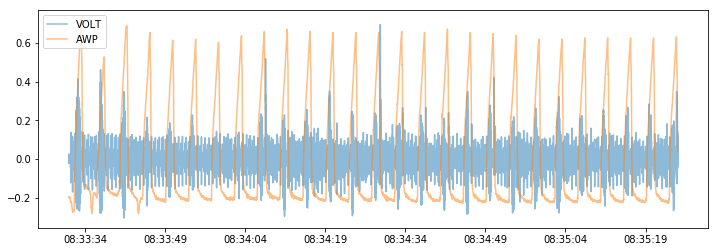

count 27 27


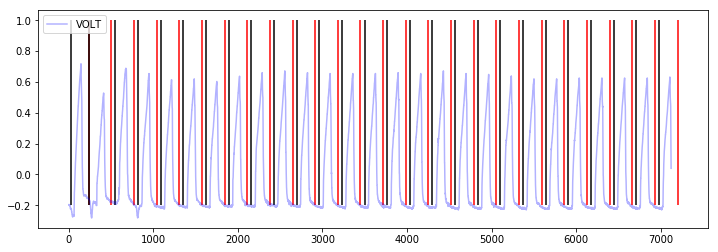

HPSS 27
draw_spectrum 27


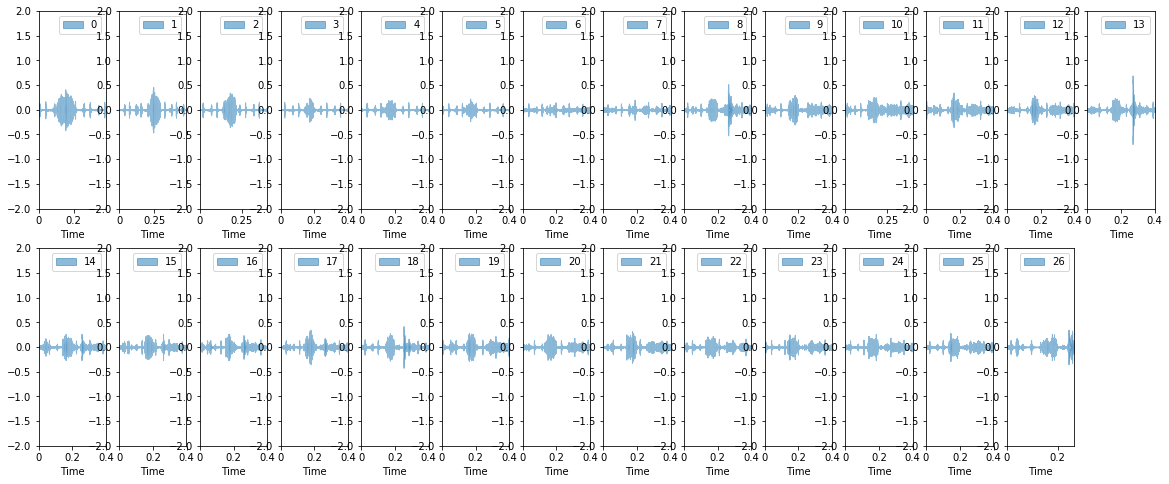

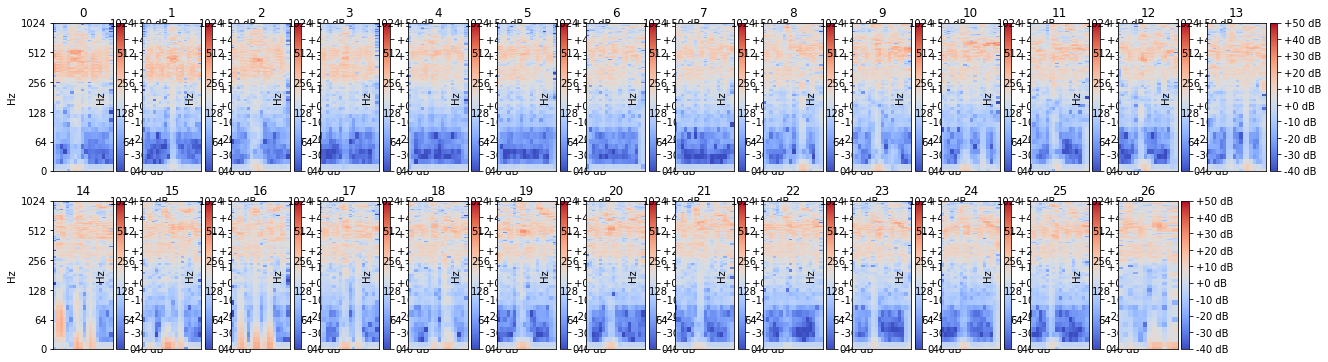

draw_MFCC 27


/home/keewon/.local/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<Figure size 432x288 with 0 Axes>

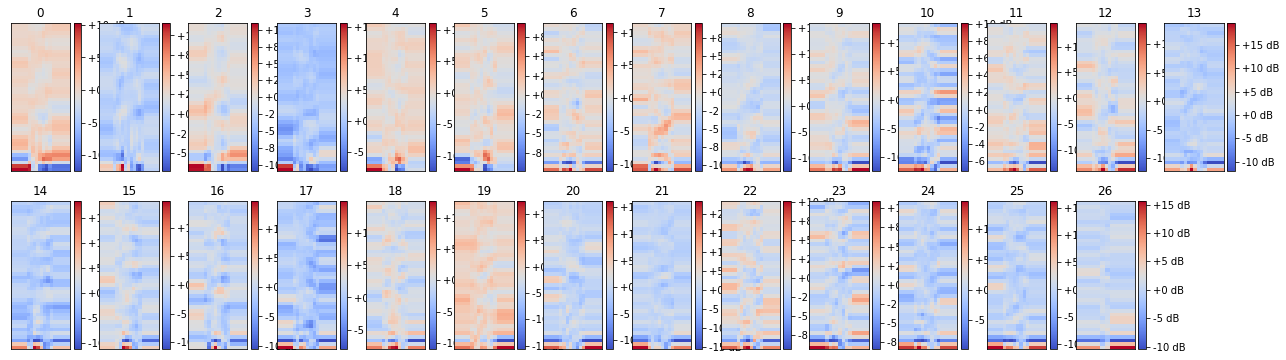

**********************************************************************
i = 3 [fname_with_time] 201852_8_44_50to201852_8_46_29_Lt OLV
new segment was found. 602 1525216993.8270123 1525216978.9470117 30 62.5
new segment was found. 11606 1525222296.867223 1525222275.2672222 30 62.5
**********************************************************************


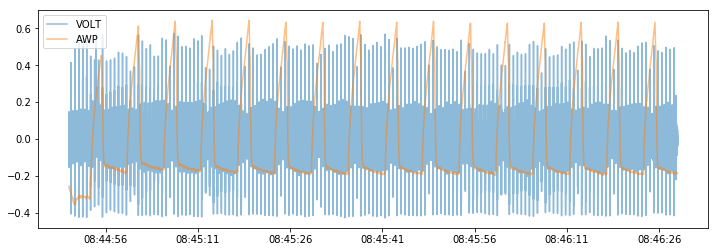

count 16 16


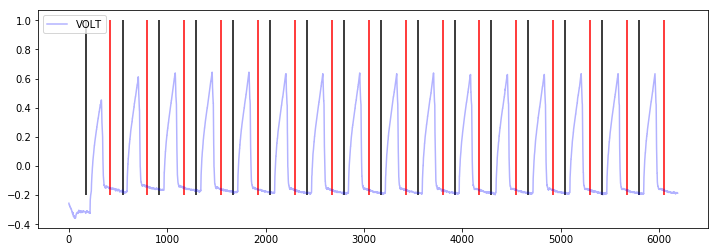

HPSS 16
draw_spectrum 16


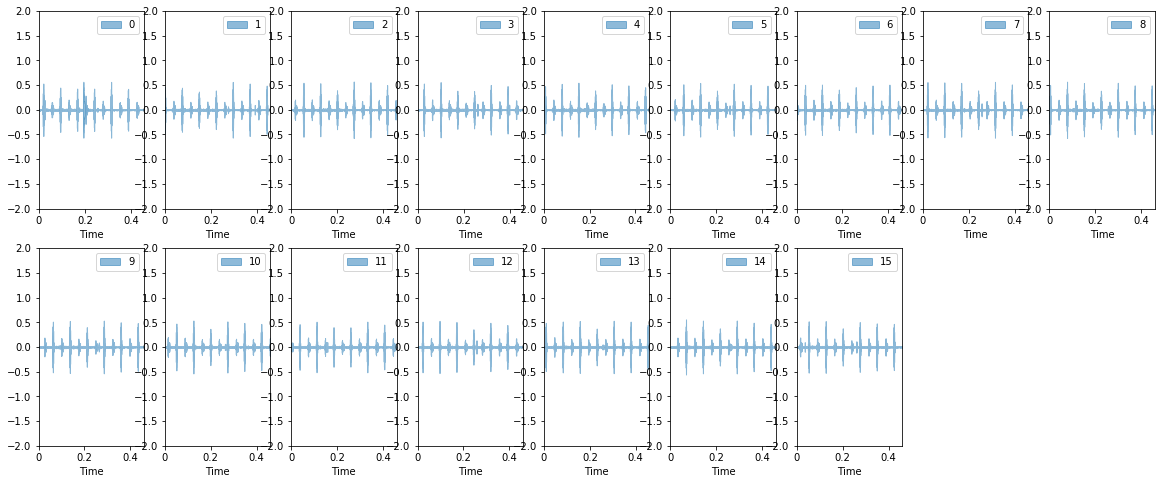

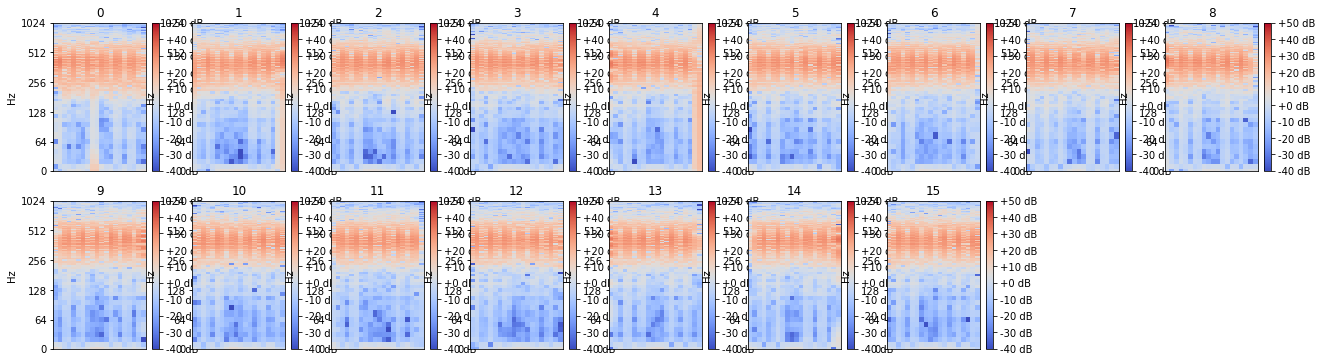

draw_MFCC 16


<Figure size 432x288 with 0 Axes>

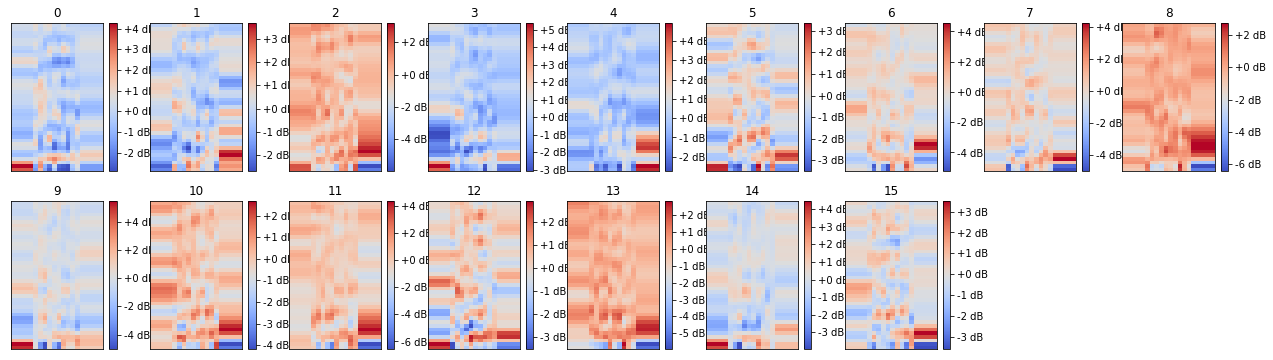

**********************************************************************
i = 4 [fname_with_time] 201852_8_46_29to201852_8_46_42_TLV
new segment was found. 602 1525216993.8270123 1525216978.9470117 30 62.5
new segment was found. 11606 1525222296.867223 1525222275.2672222 30 62.5
**********************************************************************


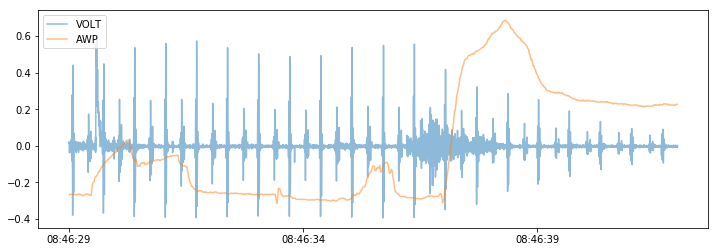

count 2 2


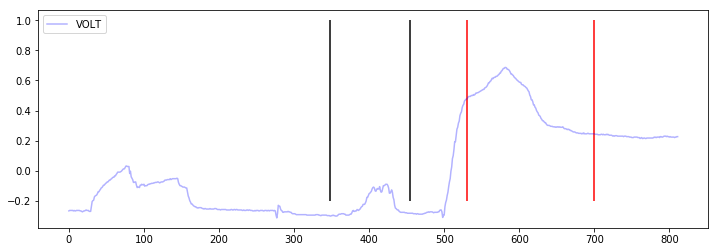

HPSS 2
draw_spectrum 2


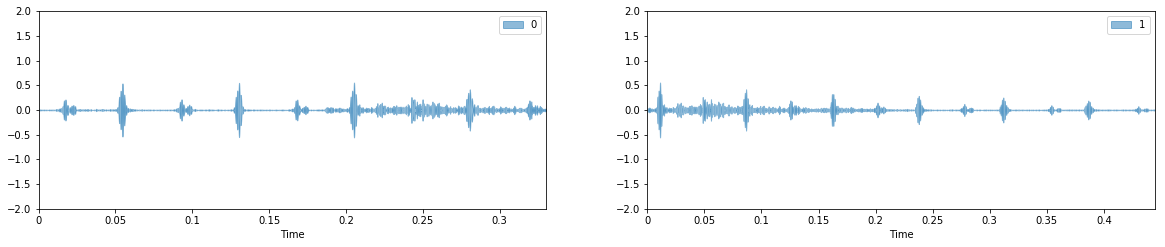

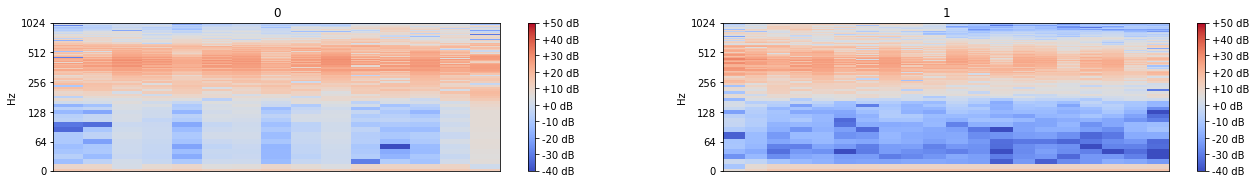

draw_MFCC 2


<Figure size 432x288 with 0 Axes>

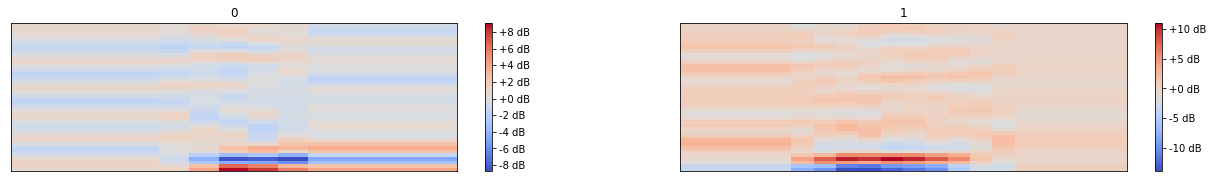

**********************************************************************
i = 5 [fname_with_time] 201852_8_46_42to201852_8_48_7_VCM
new segment was found. 602 1525216993.8270123 1525216978.9470117 30 62.5
new segment was found. 11606 1525222296.867223 1525222275.2672222 30 62.5
**********************************************************************


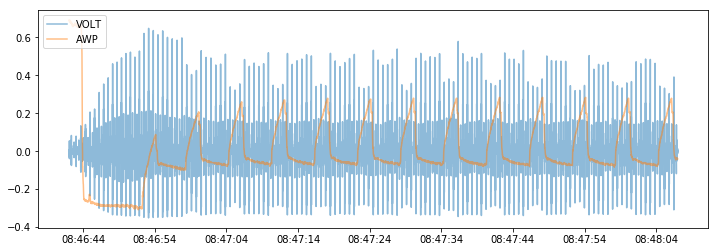

In [ ]:
for i in range(0,len(df_dict["Time"])-1):
    if df_dict["State"].isnull()[i] == False:
        if df_dict["State"][i]=="TLV" or df_dict["State"][i]=="Lt OLV" or df_dict["State"][i]=="Rt OLV" or df_dict["State"][i]=="VCM":
            fname_with_time = str(get_state_time(i)[0])+str(get_state_time(i)[1])+str(get_state_time(i)[2])+'_'+str(get_state_time(i)[3])+'_'+str(get_state_time(i)[4])+'_'+str(get_state_time(i)[5])+'to'+str(get_state_time(i)[6])+str(get_state_time(i)[7])+str(get_state_time(i)[8])+'_'+str(get_state_time(i)[9])+'_'+str(get_state_time(i)[10])+'_'+str(get_state_time(i)[11])+'_'+get_state_time(i)[12]
            print("*"*70)
            print('i =',i,'[fname_with_time]',fname_with_time)
            
            column_name=[]
            total_df=[]

            for j in range(0,len(device0_signal)+len(device1_signal)+len(device2_signal)):
                temp=[]
                if j<len(device0_signal):
                    temp = vr_data.read_wave_datetime_interval(device0_name,device0_signal[j],datetime.datetime(get_state_time(j)[0],get_state_time(i)[1],get_state_time(i)[2],get_state_time(i)[3],get_state_time(i)[4],get_state_time(i)[5]),datetime.datetime(get_state_time(i)[6],get_state_time(i)[7],get_state_time(i)[8],get_state_time(i)[9],get_state_time(i)[10],get_state_time(i)[11]))
                    time_df = pd.DataFrame(temp[0])
                    signal_df = pd.DataFrame(temp[1])
                    signal_df = (signal_df - signal_df.mean())/(signal_df.max()-signal_df.min())
                    total_df = pd.concat([time_df, signal_df],ignore_index=False, axis=1)
                    column_name.append("Time_"+device0_signal[j])
                    column_name.append(device0_signal[j])

                elif j<len(device0_signal)+len(device1_signal):
                    temp = vr_data.read_number_datetime_interval(device1_name,device1_signal[j-len(device0_signal)],datetime.datetime(get_state_time(i)[0],get_state_time(i)[1],get_state_time(i)[2],get_state_time(i)[3],get_state_time(i)[4],get_state_time(i)[5]),datetime.datetime(get_state_time(i)[6],get_state_time(i)[7],get_state_time(i)[8],get_state_time(i)[9],get_state_time(i)[10],get_state_time(i)[11]))
                    time_df = pd.DataFrame(temp[0])
                    signal_df = pd.DataFrame(temp[1])
                    signal_df = (signal_df - signal_df.mean())/(signal_df.max()-signal_df.min())
                    total_df = pd.concat([total_df,time_df, signal_df],ignore_index=False, axis=1)
                    column_name.append("Time_"+device1_signal[j-len(device0_signal)])
                    column_name.append(device1_signal[j-len(device0_signal)])

                else:
                    temp = vr_data.read_wave_datetime_interval(device2_name,device2_signal[j-len(device0_signal)-len(device1_signal)],datetime.datetime(get_state_time(i)[0],get_state_time(i)[1],get_state_time(i)[2],get_state_time(i)[3],get_state_time(i)[4],get_state_time(i)[5]),datetime.datetime(get_state_time(i)[6],get_state_time(i)[7],get_state_time(i)[8],get_state_time(i)[9],get_state_time(i)[10],get_state_time(i)[11]))
                    time_df = pd.DataFrame(temp[0])
                    signal_df = pd.DataFrame(temp[1])
                    signal_df = (signal_df - signal_df.mean())/(signal_df.max()-signal_df.min())
                    total_df = pd.concat([total_df,time_df, signal_df],ignore_index=False, axis=1)
                    column_name.append("Time_"+device2_signal[j-len(device0_signal)-len(device1_signal)])
                    column_name.append(device2_signal[j-len(device0_signal)-len(device1_signal)])

            total_df.columns = column_name
#             print(total_df.head(3))
            print('*'*70)
            make_output_dirs()
            extract_original_wav()
            HPSS()
            draw_spectrum()
            draw_MFCC()

print("Processing finished!!!")